In [8]:
import pandas as pd
import numpy as np

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

from sklearn.model_selection import GridSearchCV, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix,  roc_curve, precision_recall_curve
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("../parkinsons_disease_data.csv")
df = df[["Age", "UPDRS", "MoCA", "FunctionalAssessment", "Diagnosis"]]
X = df.drop('Diagnosis', axis=1).values
y = df['Diagnosis'].values

results = []

In [10]:
# ==================== МГУА РЕАЛІЗАЦІЯ ====================

class GMDHTransformer(BaseEstimator, TransformerMixin):
    """
    МГУА (Метод Групового Урахування Аргументів) трансформер
    Створює полиноміальні комбінації ознак та відбирає найкращі
    """
    def __init__(self, n_layers=2, max_features=50, selection_method='mutual_info'):
        self.n_layers = n_layers
        self.max_features = max_features
        self.selection_method = selection_method
        self.selectors_ = []
        self.feature_indices_ = []
        
    def _create_polynomial_combinations(self, X):
        """Створює полиноміальні комбінації пар ознак"""
        n_samples, n_features = X.shape
        new_features = []
        
        # Обмежуємо кількість комбінацій для швидкості
        max_pairs = min(15, n_features)
        
        for i in range(max_pairs):
            for j in range(i + 1, max_pairs):
                x_i = X[:, i].reshape(-1, 1)
                x_j = X[:, j].reshape(-1, 1)
                
                # Полиноміальні комбінації: a*x1 + b*x2 + c*x1*x2 + d*x1^2 + e*x2^2
                new_features.append((x_i + x_j).ravel())
                new_features.append((x_i * x_j).ravel())
                new_features.append((x_i ** 2).ravel())
                new_features.append((x_j ** 2).ravel())
                
                # Додаткові комбінації
                new_features.append(np.sqrt(np.abs(x_i * x_j)).ravel())
                new_features.append(np.log1p(np.abs(x_i + x_j)).ravel())
        
        if new_features:
            return np.column_stack(new_features)
        return np.array([]).reshape(n_samples, 0)
    
    def fit(self, X, y):
        """Навчання МГУА трансформера"""
        current_X = X.copy()
        
        for layer in range(self.n_layers):
            # Створюємо нові ознаки
            new_features = self._create_polynomial_combinations(current_X)
            
            if new_features.shape[1] > 0:
                # Об'єднуємо оригінальні та нові ознаки
                current_X = np.column_stack([current_X, new_features])
                
                # Відбір найкращих ознак
                k = min(self.max_features, current_X.shape[1])
                
                if self.selection_method == 'mutual_info':
                    selector = SelectKBest(mutual_info_classif, k=k)
                else:
                    selector = SelectKBest(f_classif, k=k)
                
                current_X = selector.fit_transform(current_X, y)
                self.selectors_.append(selector)
                
                # Зберігаємо індекси відібраних ознак
                selected_indices = selector.get_support(indices=True)
                self.feature_indices_.append(selected_indices)
        
        return self
    
    def transform(self, X):
        """Трансформація даних через МГУА"""
        current_X = X.copy()
        
        for layer, selector in enumerate(self.selectors_):
            # Створюємо нові ознаки
            new_features = self._create_polynomial_combinations(current_X)
            
            if new_features.shape[1] > 0:
                # Об'єднуємо оригінальні та нові ознаки
                current_X = np.column_stack([current_X, new_features])
                
                # Застосовуємо відбір ознак
                current_X = selector.transform(current_X)
        
        return current_X


class SimpleGMDH(BaseEstimator, TransformerMixin):
    """
    Спрощена версія МГУА з фокусом на швидкість
    """
    def __init__(self, degree=2, max_features=100):
        self.degree = degree
        self.max_features = max_features
        self.selector_ = None
        
    def fit(self, X, y):
        # Створюємо полиноміальні ознаки
        poly = PolynomialFeatures(degree=self.degree, 
                                   interaction_only=False,
                                   include_bias=False)
        X_poly = poly.fit_transform(X)
        
        # Відбираємо найкращі ознаки
        k = min(self.max_features, X_poly.shape[1])
        self.selector_ = SelectKBest(mutual_info_classif, k=k)
        self.selector_.fit(X_poly, y)
        
        return self
    
    def transform(self, X):
        poly = PolynomialFeatures(degree=self.degree, 
                                   interaction_only=False,
                                   include_bias=False)
        X_poly = poly.fit_transform(X)
        return self.selector_.transform(X_poly)


# ==================== ФУНКЦІЇ ВІЗУАЛІЗАЦІЇ ====================

def model_performance(model, subtitle, X_data=None, y_data=None):
    """Візуалізація продуктивності моделі"""
    if X_data is None:
        X_data = X
    if y_data is None:
        y_data = y
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 1
    
    for train, test in cv.split(X_data, y_data):
        model.fit(X_data[train], y_data[train])
        pred_proba = model.predict_proba(X_data[test])
        precision, recall, _ = precision_recall_curve(y_data[test], pred_proba[:, 1])
        y_real.append(y_data[test])
        y_proba.append(pred_proba[:, 1])
        fpr, tpr, t = roc_curve(y_data[test], pred_proba[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    y_pred = cross_val_predict(model, X_data, y_data, cv=5)
    conf_matrix = confusion_matrix(y_data, y_pred)
    trace1 = go.Heatmap(z=conf_matrix, x=["0 (pred)", "1 (pred)"],
                        y=["0 (true)", "1 (true)"], xgap=2, ygap=2,
                        colorscale='Viridis', showscale=False)
    
    tp = conf_matrix[1, 1]
    fn = conf_matrix[1, 0]
    fp = conf_matrix[0, 1]
    tn = conf_matrix[0, 0]
    Accuracy = ((tp + tn) / (tp + tn + fp + fn))
    Precision = (tp / (tp + fp))
    Recall = (tp / (tp + fn))
    F1_score = (2 * (((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp)) + (tp / (tp + fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy, Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x=(show_metrics[0].values),
                    y=['Accuracy', 'Precision', 'Recall', 'F1_score'], 
                    text=np.round(show_metrics[0].values, 4),
                    textposition='auto', textfont=dict(color='black'),
                    orientation='h', opacity=1, marker=dict(
            color=colors,
            line=dict(color='#000000', width=1.5)))

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name="Roc : ",
                        line=dict(color=('rgb(22, 96, 167)'), width=2), fill='tozeroy')
    trace4 = go.Scatter(x=[0, 1], y=[0, 1],
                        line=dict(color=('black'), width=1.5,
                                  dash='dot'))
    
    y_real = y_data
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    trace5 = go.Scatter(x=recall, y=precision,
                        name="Precision" + str(precision),
                        line=dict(color=('lightcoral'), width=2), fill='tozeroy')
    
    mean_auc = round(mean_auc, 3)
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False,
                            specs=[[{}, {}],
                                   [{}, {}]],
                            subplot_titles=('Confusion Matrix',
                                            'Metrics',
                                            'ROC curve' + " " + '(' + str(mean_auc) + ')',
                                            'Precision - Recall curve',
                                            ))
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 1)
    fig.append_trace(trace5, 2, 2)
    
    fig['layout'].update(showlegend=False, title='<b>Model performance report (5 folds)</b><br>' + subtitle,
                         autosize=False, height=830, width=830,
                         plot_bgcolor='black',
                         paper_bgcolor='black',
                         margin=dict(b=195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color='white')
    fig["layout"]["yaxis1"].update(color='white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color='white')))
    fig["layout"]["yaxis2"].update(color='white')
    fig["layout"]["xaxis3"].update(dict(title="false positive rate"), color='white')
    fig["layout"]["yaxis3"].update(dict(title="true positive rate"), color='white')
    fig["layout"]["xaxis4"].update(dict(title="recall"), range=[0, 1.05], color='white')
    fig["layout"]["yaxis4"].update(dict(title="precision"), range=[0, 1.05], color='white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont = dict(color='white', size=14)
    py.iplot(fig)


def scores_table(model, subtitle, X_data=None, y_data=None):
    """Таблиця з результатами крос-валідації"""
    if X_data is None:
        X_data = X
    if y_data is None:
        y_data = y
        
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    res = []
    for sc in scores:
        scores_cv = cross_val_score(model, X_data, y_data, cv=5, scoring=sc)
        res.append(scores_cv)
    df = pd.DataFrame(res).T
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()
    df = df.rename(columns={0: 'accuracy', 1: 'precision', 2: 'recall', 3: 'f1', 4: 'roc_auc'})

    trace = go.Table(
        header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                    line=dict(color='#7D7F80'),
                    fill=dict(color='#a1c3d1'),
                    align=['center'],
                    font=dict(size=15)),
        cells=dict(values=[('1', '2', '3', '4', '5', 'mean', 'std'),
                           np.round(df['accuracy'], 3),
                           np.round(df['precision'], 3),
                           np.round(df['recall'], 3),
                           np.round(df['f1'], 3),
                           np.round(df['roc_auc'], 3)],
                   line=dict(color='#7D7F80'),
                   fill=dict(color='#EDFAFF'),
                   align=['center'], font=dict(size=15)))

    layout = dict(width=800, height=400, title='<b>Cross Validation - 5 folds</b><br>' + subtitle, 
                  font=dict(size=15))
    fig = dict(data=[trace], layout=layout)

    py.iplot(fig, filename='styled_table')

In [11]:
# ==================== БАЗОВИЙ LIGHTGBM (БЕЗ МГУА) ====================

random_state = 42

fit_params = {"eval_metric": 'auc',
              "eval_set": [(X, y)],
              'eval_names': ['valid'],
              'categorical_feature': 'auto'}

param_test = {'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1],
              'n_estimators': [200, 300, 400, 500, 800, 1000, 1500],
              'num_leaves': sp_randint(15, 45),
              'min_child_samples': sp_randint(50, 300),
              'min_child_weight': [1e-3, 1e-2, 1e-1, 1],
              'subsample': sp_uniform(loc=0.5, scale=0.4),
              'max_depth': [3, 4, 5, 6, 7, 8],
              'colsample_bytree': sp_uniform(loc=0.5, scale=0.4),
              'reg_alpha': [0, 0.1, 1, 5, 10],
              'reg_lambda': [0, 1, 5, 10, 20],
              'min_split_gain': [0, 0.01, 0.1, 0.5]}

n_iter = 300

lgbm_clf = lgbm.LGBMClassifier(
    random_state=random_state,
    verbose=-1,
    metric='None',
    n_jobs=-1,
    is_unbalanced=True,
    scale_pos_weight=400 / 214)

grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test,
    n_iter=n_iter,
    scoring='f1',  # Змінено на F1!
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    refit=True,
    random_state=random_state,
    verbose=True,
    n_jobs=-1)

print("🔍 Оптимізація базового LightGBM...")
grid_search.fit(X, y, **fit_params)
opt_parameters = grid_search.best_params_
lgbm_clf_base = lgbm.LGBMClassifier(**opt_parameters)

print(f"\n✅ Найкращі параметри: {opt_parameters}")
print(f"✅ Найкращий F1 score: {grid_search.best_score_:.4f}")

🔍 Оптимізація базового LightGBM...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits

✅ Найкращі параметри: {'colsample_bytree': 0.8223459546964573, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 296, 'min_child_weight': 0.1, 'min_split_gain': 0.1, 'n_estimators': 1500, 'num_leaves': 22, 'reg_alpha': 10, 'reg_lambda': 10, 'subsample': 0.8989022139073577}
✅ Найкращий F1 score: 0.8512


In [12]:
# Результати базового LightGBM
print("\n" + "="*60)
print("БАЗОВИЙ LIGHTGBM (БЕЗ МГУА)")
print("="*60)
model_performance(lgbm_clf_base, 'LightGBM (базовий)')
scores_table(lgbm_clf_base, 'LightGBM (базовий)')


БАЗОВИЙ LIGHTGBM (БЕЗ МГУА)


In [13]:
# ==================== МГУА + LIGHTGBM ====================

print("\n" + "="*60)
print("ЗАСТОСУВАННЯ МГУА")
print("="*60)

# Варіант 1: Спрощений МГУА (швидший)
print("\n🔧 Створення МГУА ознак (спрощена версія)...")
gmdh_simple = SimpleGMDH(degree=2, max_features=80)
X_gmdh_simple = gmdh_simple.fit_transform(X, y)
print(f"✅ Ознак після МГУА: {X_gmdh_simple.shape[1]} (було: {X.shape[1]})")

# Оптимізація LightGBM на МГУА ознаках
lgbm_gmdh = lgbm.LGBMClassifier(
    random_state=random_state,
    verbose=-1,
    metric='None',
    n_jobs=-1,
    is_unbalanced=True,
    scale_pos_weight=400 / 214)

grid_search_gmdh = RandomizedSearchCV(
    estimator=lgbm_gmdh, param_distributions=param_test,
    n_iter=200,  # Менше ітерацій для швидкості
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    refit=True,
    random_state=random_state,
    verbose=True,
    n_jobs=-1)

print("\n🔍 Оптимізація LightGBM на МГУА ознаках...")
grid_search_gmdh.fit(X_gmdh_simple, y)
opt_parameters_gmdh = grid_search_gmdh.best_params_
lgbm_clf_gmdh = lgbm.LGBMClassifier(**opt_parameters_gmdh)

print(f"\n✅ Найкращий F1 score з МГУА: {grid_search_gmdh.best_score_:.4f}")
print(f"📊 Покращення: {(grid_search_gmdh.best_score_ - grid_search.best_score_) * 100:.2f}%")


ЗАСТОСУВАННЯ МГУА

🔧 Створення МГУА ознак (спрощена версія)...
✅ Ознак після МГУА: 14 (було: 4)

🔍 Оптимізація LightGBM на МГУА ознаках...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

✅ Найкращий F1 score з МГУА: 0.8529
📊 Покращення: 0.17%


In [14]:
# Результати МГУА + LightGBM
print("\n" + "="*60)
print("LIGHTGBM З МГУА ОЗНАКАМИ")
print("="*60)
model_performance(lgbm_clf_gmdh, 'LightGBM + МГУА', X_gmdh_simple, y)
scores_table(lgbm_clf_gmdh, 'LightGBM + МГУА', X_gmdh_simple, y)


LIGHTGBM З МГУА ОЗНАКАМИ


In [16]:
# ==================== АНСАМБЛЬ: МГУА + LIGHTGBM + KNN ====================

print("\n" + "="*60)
print("СТВОРЕННЯ АНСАМБЛЮ")
print("="*60)

# Оптимізація KNN на МГУА ознаках
print("\n🔧 Оптимізація KNN...")
knn_params = {'n_neighbors': np.arange(3, 30)}
knn_clf = KNeighborsClassifier(weights='distance')

grid_knn = GridSearchCV(
    estimator=knn_clf,
    param_grid=knn_params,
    cv=5,
    scoring='f1',
    n_jobs=-1)

grid_knn.fit(X_gmdh_simple, y)
best_k = grid_knn.best_params_['n_neighbors']
print(f"✅ Найкращий K для KNN: {best_k}")

# Створення ансамблю
knn_clf_opt = KNeighborsClassifier(n_neighbors=best_k, weights='distance')

voting_clf_gmdh = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_clf_gmdh),
        ('knn', knn_clf_opt)
    ],
    voting='soft',
    weights=[2, 1])  # Більша вага LightGBM

print("\n✅ Ансамбль створено!")


СТВОРЕННЯ АНСАМБЛЮ

🔧 Оптимізація KNN...
✅ Найкращий K для KNN: 28

✅ Ансамбль створено!


In [17]:
# Результати ансамблю
print("\n" + "="*60)
print("АНСАМБЛЬ: МГУА + LIGHTGBM + KNN")
print("="*60)
model_performance(voting_clf_gmdh, 'МГУА + LightGBM + KNN', X_gmdh_simple, y)
scores_table(voting_clf_gmdh, 'МГУА + LightGBM + KNN', X_gmdh_simple, y)


АНСАМБЛЬ: МГУА + LIGHTGBM + KNN


In [18]:
# ==================== ПОРІВНЯННЯ РЕЗУЛЬТАТІВ ====================

print("\n" + "="*80)
print("ПОРІВНЯННЯ ВСІХ МОДЕЛЕЙ")
print("="*80)

models = [
    (lgbm_clf_base, "Базовий LightGBM", X, y),
    (lgbm_clf_gmdh, "LightGBM + МГУА", X_gmdh_simple, y),
    (voting_clf_gmdh, "Ансамбль (МГУА + LGBM + KNN)", X_gmdh_simple, y)
]

comparison_results = []

for model, name, X_data, y_data in models:
    scores_dict = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        scores = cross_val_score(model, X_data, y_data, cv=5, scoring=metric)
        scores_dict[metric] = scores.mean()
    scores_dict['model'] = name
    comparison_results.append(scores_dict)

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']]

print("\n")
print(comparison_df.to_string(index=False))
print("\n" + "="*80)


ПОРІВНЯННЯ ВСІХ МОДЕЛЕЙ


                       model  accuracy  precision   recall       f1  roc_auc
            Базовий LightGBM  0.793824   0.793794 0.901857 0.844330 0.864154
             LightGBM + МГУА  0.795724   0.794379 0.904928 0.845993 0.864420
Ансамбль (МГУА + LGBM + KNN)  0.796675   0.792141 0.911061 0.847379 0.861315



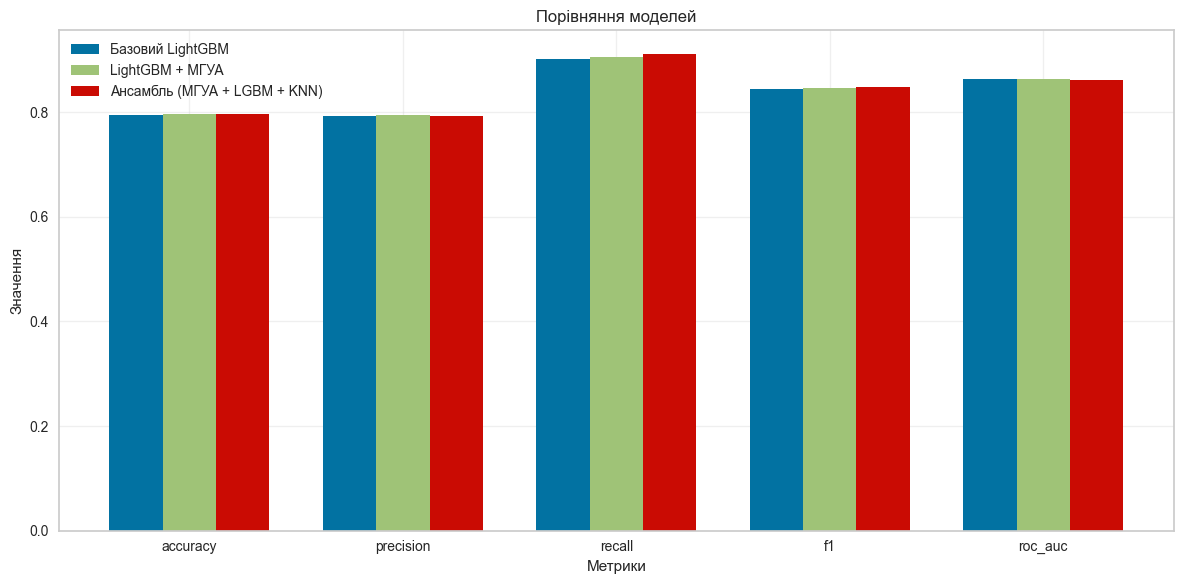

In [19]:
# Візуалізація покращень
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics))
width = 0.25

for i, row in comparison_df.iterrows():
    values = [row[m] for m in metrics]
    ax.bar(x + i*width, values, width, label=row['model'])

ax.set_xlabel('Метрики')
ax.set_ylabel('Значення')
ax.set_title('Порівняння моделей')
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

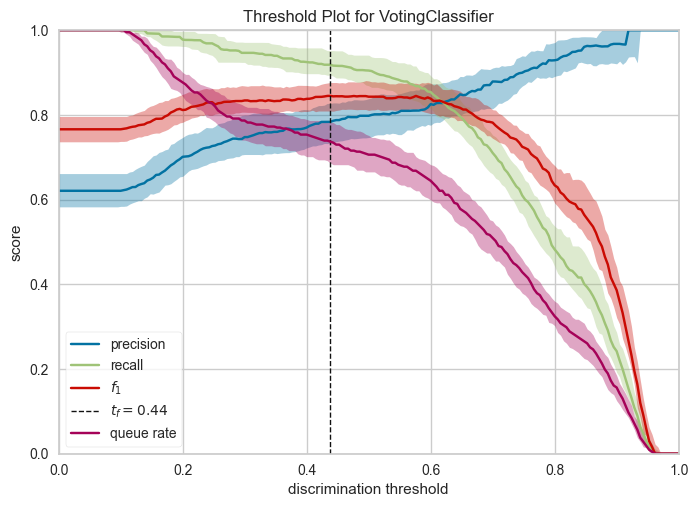

<Axes: title={'center': 'Threshold Plot for VotingClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [20]:
# Discrimination Threshold для найкращої моделі
visualizer = DiscriminationThreshold(voting_clf_gmdh)
visualizer.fit(X_gmdh_simple, y)
visualizer.poof()